# <span id="toc">  Esercitazione 2 - Importance Sampling </span>

[  2.1 - Calcolo integrale a campionamento ](#ex-2.1)

[  2.2 - Random walk ](#ex-2.2)

## <span id="ex-2.1">  Esercizio 2.1 </span>[^](#toc)


In questo esercizio vogliamo calcolare con metodi Monte Carlo il seguente integrale, il cui risultato è noto analiticamente
$$
I = \int_0^1 \frac{\pi}{2}\cos(\pi x/2) dx = 1
$$

Utilizzeremo innanzitutto il metodo della media, con **campionamento uniforme** nell'intervallo $[0,1)$. Poi eseguiamo lo stesso calcolo usando il metodo dell'**importance sampling**, che permette di estrarre numeri casuali secondo una distribuzione di probabilità $p(x)$ fissata (più simile possibile all'integranda): in questo modo vengono campionate più intensamente zone del dominio in cui la funzione ha valori significativamente diversi da $0$.

In linea di principio, se sapessi campionare con $p(x)$ proprio uguale all'integranda, il risultato potrebbe essere trovato con varianza che tende a $0$; di fatto, utilizzando una $p(x)$ *simile* all'integranda, siamo in grado di ridurre notevolmente la varianza delle stime dell'integrale.

Un limite nella ricerca della $p(x)$ sta nel fatto che essa dev'essere **positiva** nel dominio, **finita** (eccetto in punti a misura nulla), **normalizzata**: $\int_0^1 p(x) dx =1$. Soprattutto però dobbiamo essere in grado di invertirne analiticamente la CDF [Es-1.2](https://github.com/martinozanetti/LSN-Martino-Zanetti/blob/master/01-ok/my-01.ipynb).

La scelta più semplice è in questo caso (si può visualizzare [qui](https://www.desmos.com/calculator) la bontà della somiglianza con l'integranda)
$$
p(x) = 2(1-x)
$$
e l'inversione della sua CDF dà $x=1-\sqrt{1-y}$, con $y$ generato casualmente tra 0 e 1.


### Osservazione

La funzione lineare approssima meglio l'integranda rispetto alla distribuzione uniforme, quindi utilizzando il meteodo dell'importance sampling ci aspettiamo che l'integrale converga più velocemente e in modo più effeiciente al risultato atteso.
**Questo è vero sempre! La più semplice approssimazione lineare (e.g. fit con minimizzazione degli scarti quadrati) è sempre meglio della distribuzione uniforme, che in effetti è una distribuzione lineare degenere**.


### a) Campionamento uniforme in $[0,1]$

Per questo esercizio non è stato necessario modificare la classe ```Random```, siccome essa conteneva già un metodo per il campionamento uniforme tra 0 e 1.

Come nell'[Es-1](https://github.com/martinozanetti/LSN-Martino-Zanetti/blob/master/01-ok/my-01.ipynb), usiamo il metodo del data-blocking per osservare l'andamento degli errori, quindi visualizzare la velocità di convergenza dell'algoritmo.

In questo caso abbiamo usato $100$ blocchi da $10^4$ step ciascuno.

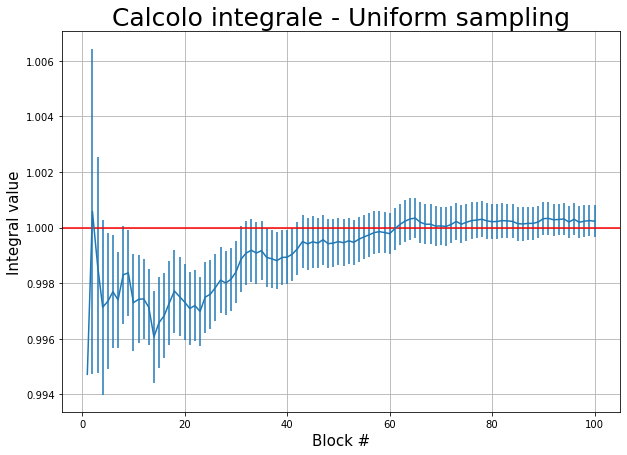

Risultato finale : 
1.00023

Incertezza : 
0.000565679


In [14]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

N = 100
x = np.arange(N)+1      # uso l'ordinamento da 1 a N

fig=plt.figure(figsize=(10,7))

ave, err = np.loadtxt("ex2-1/results.out", usecols=(0,1), delimiter=' ', unpack='true')
plt.errorbar(x, ave, yerr = err)
plt.xlabel('Block #', fontsize = 15)
plt.ylabel('Integral value', fontsize = 15)
plt.title("Calcolo integrale - Uniform sampling", fontsize = 25)
plt.grid(True)
plt.axhline(y=1, color = 'r', linestyle = '-')

plt.show()

print('Risultato finale : ')
print(ave[-1])
print('\nIncertezza : ')
print(err[-1])

### b) Importance sampling in $[0,1]$

In questo caso è stato necessario modificare la classe ```Random```, aggiungendo un metodo ```Linear``` che campiona linearmente con $p(x) = 2(1-x)$, tra 0 e 1.

Usiamo ancora il metodo del data-blocking con i parametri precedenti.

Nello sfondo è impresso per confronto il grafico del punto precedente.

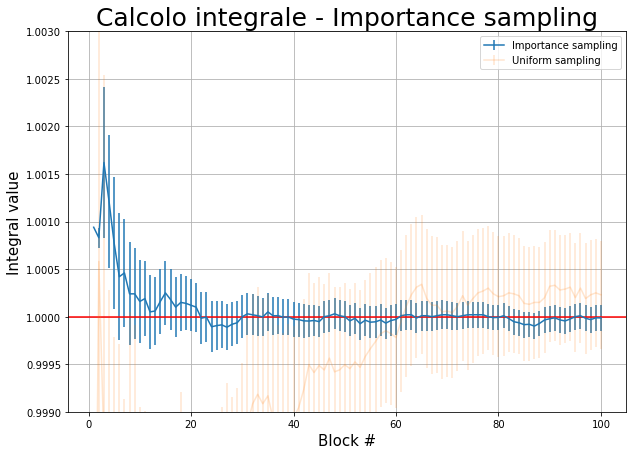

Risultato finale : 
0.999987

Incertezza : 
0.000134136


In [19]:
# continuo a usare variabili dichiarate al punto precedente

fig=plt.figure(figsize=(10,7))

ave_inv, err_inv  = np.loadtxt("ex2-1/results_IS.out", usecols=(0,1), delimiter=' ', unpack='true')
plt.errorbar(x, ave_inv, yerr = err_inv, label = "Importance sampling")

plt.errorbar(x, ave, err, alpha = 0.2, label = "Uniform sampling")
plt.ylim(0.999,1.003)


plt.xlabel('Block #', fontsize = 15)
plt.ylabel('Integral value', fontsize = 15)
plt.title("Calcolo integrale - Importance sampling", fontsize = 25)
plt.grid(True)
plt.axhline(y=1, color = 'r', linestyle = '-')
plt.legend()

plt.show()

print('Risultato finale : ')
print(ave_inv[-1])
print('\nIncertezza : ')
print(err_inv[-1])


### Osservazione

Nel secondo caso si osserva una più rapida convergenza al valore atteso, e una discreta stabilità della stima all'aumentare dei blocchi, da cui una minore varianza. Come attso, il metodo dell'importance sampling è più rapido nella convergenza e più preciso nella stima del risultato a parità di punti campionati, quindi in generale numericamente più efficiente.

Sottolineiamo che per quantificare in modo accurato quanto appena detto, sarebbe necessario ripetere tante simulazioni con seed differenti (usando il metodo ```SetSeed``` della classe ```Random```) e fare un confronto tra numerosi andamenti.


## <span id="ex-2.2">  Esercizio 2.2 </span>[^](#toc)

Vogliamo simulare un Random Walk (RW) 3D prima su un reticolo discreto, poi nello spazio continuo.

Eseguiamo $10^4$ RWs da $100$ step ciascuno, salvando la posizione. Ci aspettiamo in entrambi i casi che l'andamento di $\sqrt{\langle |\mathbf{r}_N|^2 \rangle}$
(dove $|\mathbf{r}_N|$ è la distanza del *random-walker* dall'origine al passo $N$-esimo) sia di tipo diffusivo, e che segua pertanto una
[legge diffusiva](https://en.wikipedia.org/wiki/Brownian_motion)
del tipo $f(x) = k\sqrt{N}$, dove $k$ ha un ruolo simile a una costante di diffusione.

### a) Cammino discreto

Il reticolo su cui ci muoviamo in questo caso ha celle cubiche con costante reticolare $a=1$: ogni volta il *random-walker* compie un passo **avanti** o **indietro** di lunghezza $a$, in **direzione casuale discreta** $x$, $y$ o $z$.

A livello di codice ho quindi estratto per ciascun passo una *direzione* ```step_dir``` e un *verso* ```step_sign```. 

Ancora una volta abbiamo usato il metodo del data-blocking, dividendo i $10\,000$ RWs in $100$ blocchi da $100$ RWs ciascuno. Questo ci ha permesso di visualizzare la "traiettoria" della distanza media dall'origine, con il relativo errore, quindi di eseguirne il fit e verificare che sia compatibile con una legge diffusiva.


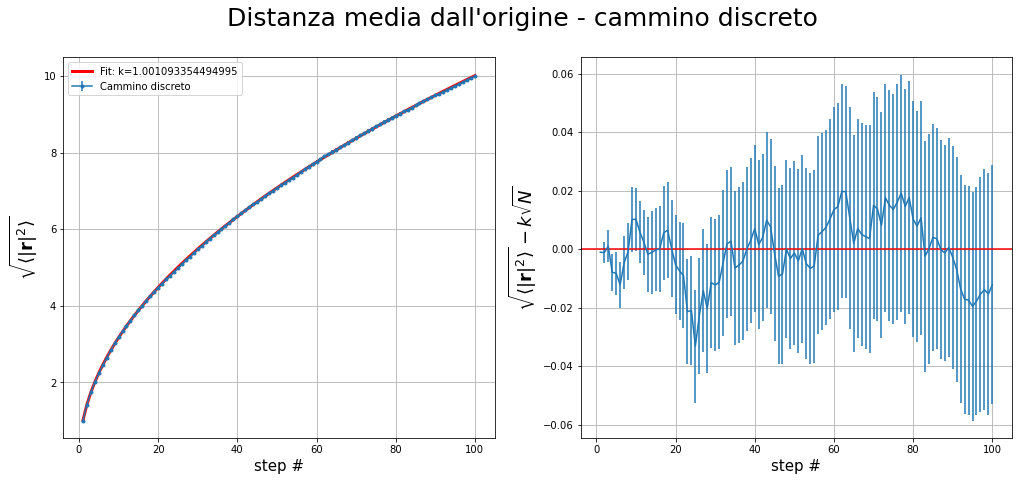

In [9]:
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np

# ======== funzione ========
def f (x, k):
    return k * np.sqrt(x)
# ==========================

N = 100
x = np.arange(N)+1      # uso l'ordinamento da 1 a N

fig=plt.figure(figsize=(17,7))
plt.suptitle("Distanza media dall'origine - cammino discreto", fontsize = 25)

#--------------- plot 1 ----------------

plt.subplot(1,2,1)
r, err = np.loadtxt("ex2-2/discrete.out", usecols=(0,1), delimiter=' ', unpack='true')
plt.errorbar(x, r, yerr = err, label = "Cammino discreto", marker = ".")
plt.xlabel('step #', fontsize = 15)
plt.ylabel(r'$\sqrt{\langle |\mathbf{r}|^2 \rangle}$', fontsize = 18)
plt.grid(True)

popt, pcov = curve_fit(f, x, r)
plt.plot(x,f(x,*popt), color='red', linewidth = 3, label='Fit: k='+str(*popt))
plt.legend()

#--------------- plot 2 ----------------

plt.subplot(1,2,2)
plt.errorbar(x, r-f(x,*popt), yerr = err)
plt.xlabel('step #', fontsize = 15)
plt.ylabel(r'$\sqrt{\langle |\mathbf{r}|^2 \rangle}-k\sqrt{N}$', fontsize = 18)
plt.axhline(y=0, color = 'r', linestyle = '-', linewidth = 1.5)

plt.grid(True)

plt.show()

### b) Cammino continuo

In questo caso lo spazio è continuo: ogni volta il ogni volta il *random-walker* compie un passo lunghezza $a$, in **direzione casuale** estratta campionando uniformemente (!!) l'angolo solido: $\theta \in [0,\pi]$ e $\phi \in [0,2\pi]$.

**ATTENZIONE**: per estrarre uniformemente su una sfera, non basta estrarre uniformemente $\theta \in [0,\pi]$ e $\phi \in [0,2\pi]$, e portarsi in coordinate sferiche: in questo modo i poli della sfera vengono sovracampionati, come mostrato nello specchietto a fondo pagina. Questo errore è particolarmente subdolo, perché con l'analisi di questo esercizio non emerge, essendo simmetrico rispetto ai poli.

Abbiamo bisogno allora di una distribuzione diversa: usiamo la [distribuzione di Phong](https://en.wikipedia.org/wiki/Phong_reflection_model) con $n=1$ attorno all'asse z, estesa anche all'emisfero inferiore.

A livello di codice l'algoritmo appare circa così: 

```c++
// direzioni random su una semisfera...
double cosThetaSq = rnd.Rannyu();
double cosTheta = sqrt(cosThetaSq);
double senTheta = sqrt(1.0 - cosThetaSq);
double phi   = rnd.Rannyu(0., 2.*M_PI);
// estensione al secondo emisfero
int up_down = ((int)rnd.Rannyu(0.,2.)*2-1); // +-1

x = senTheta*cos(phi);
y = senTheta*sin(phi);
z = cosTheta*up_down;
```

Ancora una volta abbiamo usato il metodo del data-blocking, dividendo i $10\,000$ RWs in $100$ blocchi da $100$ RWs ciascuno. Questo ci ha permesso di visualizzare la "traiettoria" della distanza media dall'origine, con il relativo errore, quindi di eseguirne il fit e verificare che sia compatibile con una legge diffusiva.

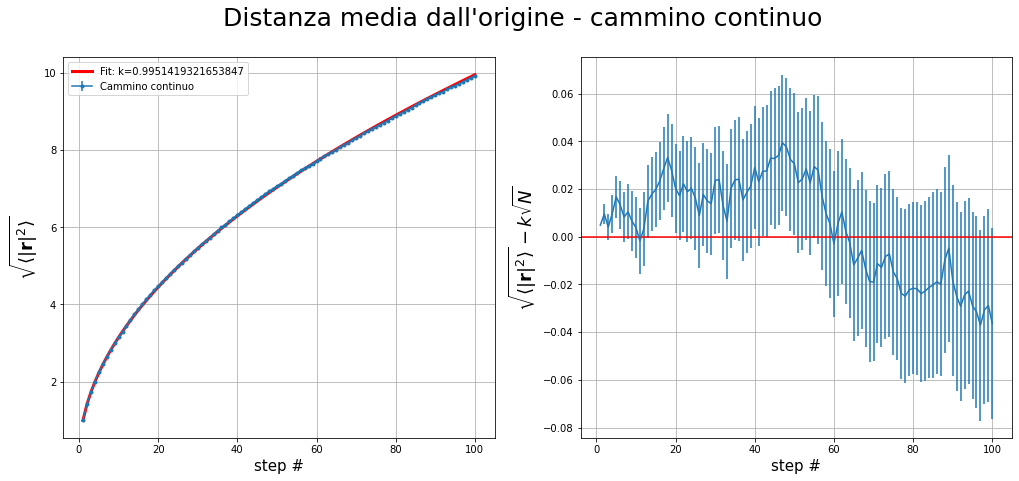

In [11]:

fig=plt.figure(figsize=(17,7))
plt.suptitle("Distanza media dall'origine - cammino continuo", fontsize = 25)

#--------------- plot 1 ----------------

plt.subplot(1,2,1)
r, err = np.loadtxt("ex2-2/continuous.out", usecols=(0,1), delimiter=' ', unpack='true')
plt.errorbar(x, r, yerr = err, label = "Cammino continuo", marker = ".")
plt.xlabel('step #', fontsize = 15)
plt.ylabel(r'$\sqrt{\langle |\mathbf{r}|^2 \rangle}$', fontsize = 18)
plt.grid(True)

popt, pcov = curve_fit(f, x, r)
plt.plot(x,f(x,*popt), color='red', linewidth = 3, label='Fit: k='+str(*popt))
plt.legend()

#--------------- plot 2 ----------------

plt.subplot(1,2,2)
plt.errorbar(x, r-f(x,*popt), yerr = err)
plt.xlabel('step #', fontsize = 15)
plt.ylabel(r'$\sqrt{\langle |\mathbf{r}|^2 \rangle}-k\sqrt{N}$', fontsize = 18)
plt.axhline(y=0, color = 'r', linestyle = '-', linewidth = 1.5,)

plt.grid(True)

plt.show()

### Conclusioni

Entrambi i grafici mostrano una discreta compatibilità con il fit $\propto \sqrt{N}$.
Questo conferma che su scale di tempo lunghe il processo di RW può essere considerato un processo diffusivo, con $k=\sqrt{2D\tau}$ dove $D$ è la costante di diffusionee $\tau$ l'intervallo di tempo.

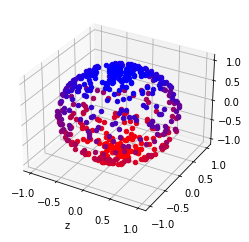

In [74]:

# per una visualizzazione ottimale, conviene eseguire con python3 lo script non_unif_sph.py

import random as rd
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for i in range(0, 500):
    th=rd.uniform(0, np.pi)
    phi=rd.uniform(0, 2*np.pi)

    xx = np.sin(th)*np.cos(phi)
    yy = np.sin(th)*np.sin(phi)
    zz = np.cos(th)
    ax.scatter(xx,yy,zz, color = [1-(zz+1)/2,0,(zz+1)/2])

plt.xlabel("x")
plt.xlabel("y")
plt.xlabel("z")

plt.show()